In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import pandas as pd  
import seaborn as sns

boston = pd.read_csv('Boston.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [2]:
boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [3]:
# check for missing values in all the columns
boston.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [4]:
# extract features and target variables
X = boston.drop(columns=['medv'])
y = boston['medv']

In [5]:
from sklearn.model_selection import train_test_split

# splits the training and test data sets in 80% / 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 5, train_size = 0.8)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(404, 13)
(102, 13)
(404,)
(102,)


### Data transformation

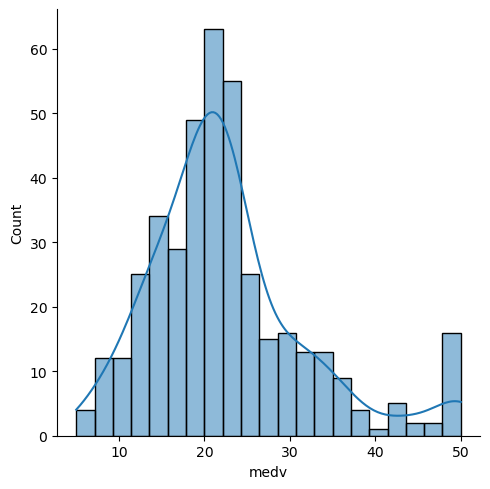

1.5244480329672944e-16


In [6]:
# Check for skewness
# Apply feature engineering on the training dataset to avoid data leakage (treat the test set as unseen data)

# plot a histogram showing the distribution of the target values
sns.displot(y_train, kde=True)
plt.show()

# statistical test
# p-value >= 0.05 means that the distribution is a normal distribution
from scipy import stats
_, p = stats.normaltest(y_train)
print(p)

0.13691572648674322


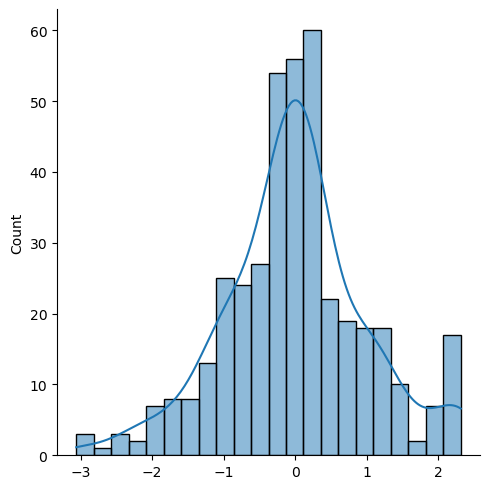

In [7]:
# y - transformation (box cox)
from sklearn.preprocessing import PowerTransformer
pt_bc = PowerTransformer(method='box-cox')
y_train_bc = pt_bc.fit_transform(y_train.to_frame()).ravel()
_, p = stats.normaltest(y_train_bc)
print(p)
sns.displot(y_train_bc, kde=True)

# apply box cox on test
y_test_bc = pt_bc.transform(y_test.to_frame()).ravel()

### Feature selection: Correlation matrix

<Axes: >

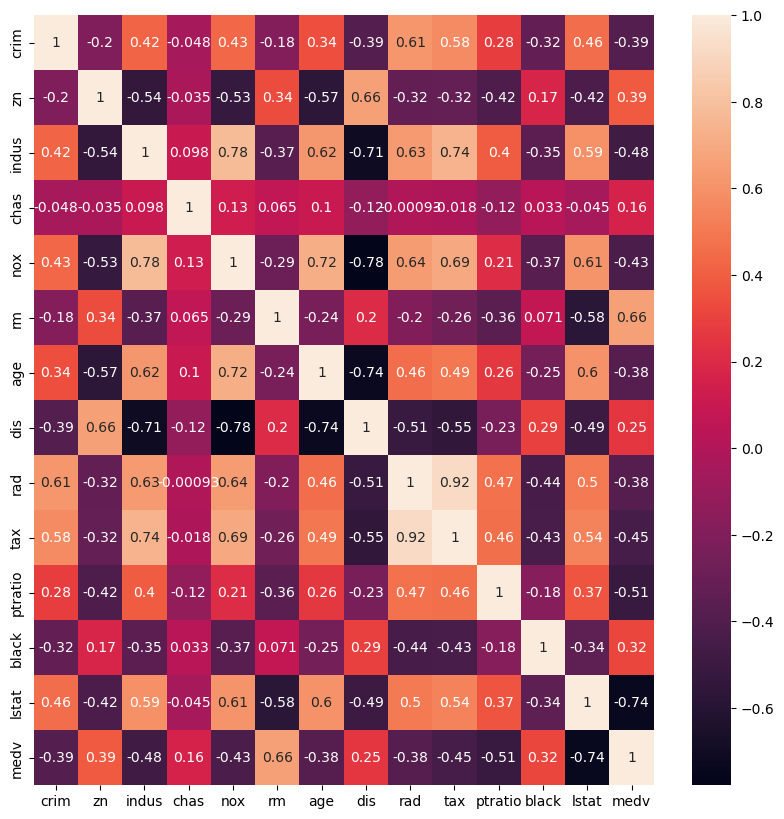

In [8]:
# compute the pair wise correlation for all columns  
correlation_matrix = pd.concat([X_train, y_train], axis=1).corr()
# use the heatmap function from seaborn to plot the correlation matrix
# Manipulate figsize in inches for 
fig, ax = plt.subplots(figsize=(10,10))
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

**Observations**
- From the above correlation plot we can see that **medv** is strongly correlated to **lstat**, **rm**
- **rad** and **tax** are stronly correlated, so we don't include this in our features together to avoid multi-colinearity

### Feature selection: Importances

Feature ranking:
1. feature 12 (0.563171)
2. feature 5 (0.173083)
3. feature 0 (0.101409)
4. feature 7 (0.062701)
5. feature 4 (0.033121)
6. feature 10 (0.027918)
7. feature 9 (0.013053)
8. feature 6 (0.010116)
9. feature 11 (0.009812)
10. feature 8 (0.003315)
11. feature 2 (0.001886)
12. feature 3 (0.000308)
13. feature 1 (0.000106)


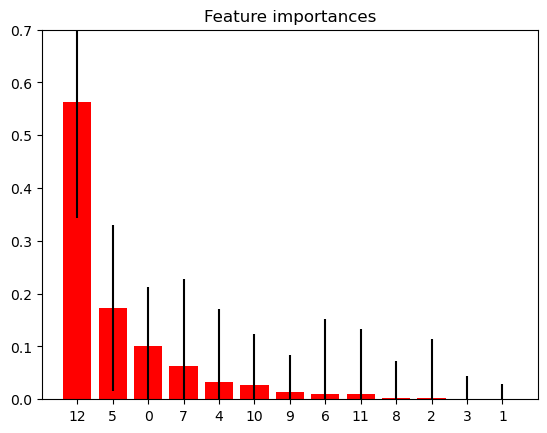

In [9]:
# Feature Importance using ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
# Build an estimator (forest of trees) and compute the feature importances
estimator = GradientBoostingRegressor(n_estimators=100, random_state=0)

estimator.fit(X_train, y_train_bc)
# Lets get the feature importances. 
# Features with high importance score higher.
importances = estimator.feature_importances_

std = np.std([tree[0].feature_importances_ for tree in estimator.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.ylim([0, 0.7])
plt.show()

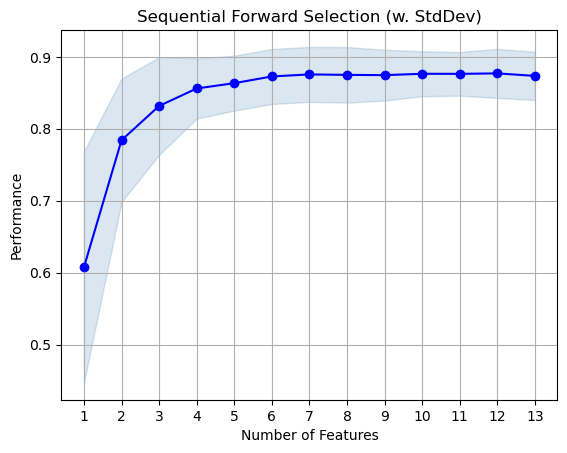

Selected features: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12)
Prediction (CV) score: 0.8770031465742208


In [10]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

sfs = SFS(estimator, 
          k_features=(2,13), 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=10)

sfs = sfs.fit(X_train, y_train_bc)

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
print('Selected features:',sfs.k_feature_idx_)
print('Prediction (CV) score:',sfs.k_score_)

In [11]:
# for simplicity and educational purposes we choose only two features
X_train = X_train[['lstat', 'rm']]
X_test = X_test[['lstat', 'rm']]

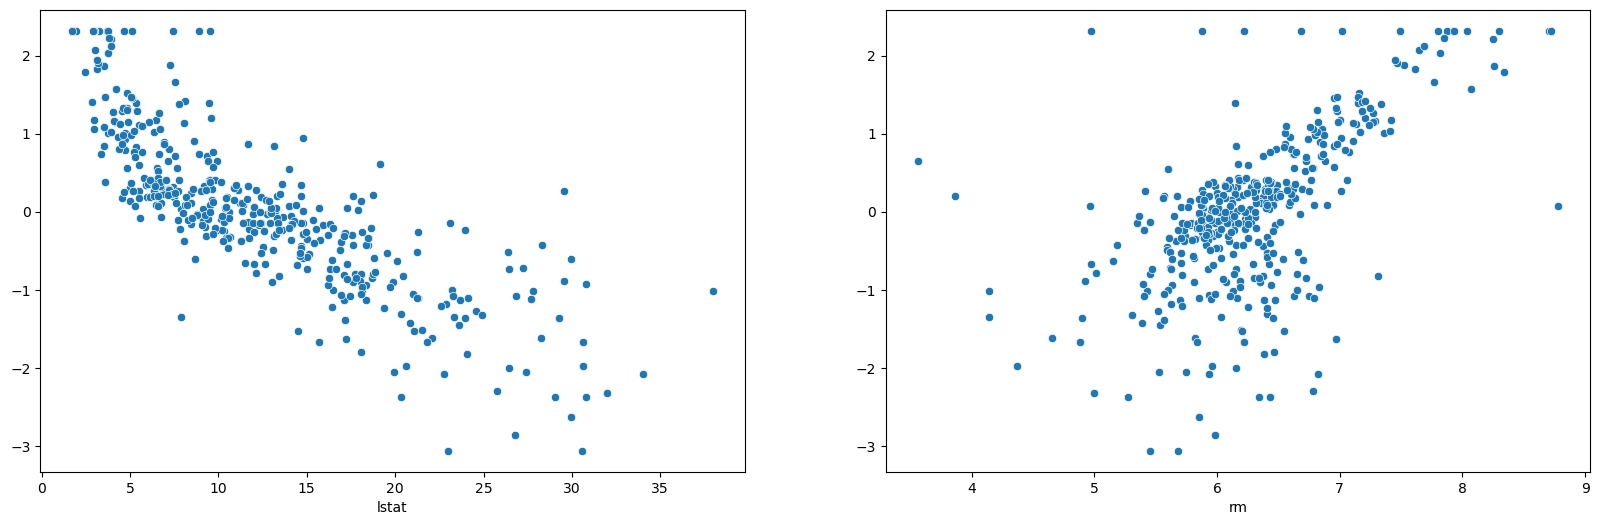

In [12]:
plt.figure(1,figsize=(20,6))
plt.subplot(121)
sns.scatterplot(x = X_train['lstat'], y = y_train_bc)
plt.subplot(122)
sns.scatterplot(x = X_train['rm'], y = y_train_bc)
plt.show()

## Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# linear regression with data transformations

lr1 = LinearRegression()

# model training
lin_model1 = lr1.fit(X_train, y_train)

# model evaluation for validation set
y_test_predict = lin_model1.predict(X_test)

# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(y_test, y_test_predict)))

# r-squared score of the model
r2 = r2_score(y_test, y_test_predict)

print("Model performance on test dataset")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

Model performance on test dataset
--------------------------------------
RMSE is 5.137400784702911
R2 score is 0.6628996975186953


In [14]:
# linear regrassion on transformed data (unskewed target variable)

lr2 = LinearRegression()

# model training
lin_model2 = lr2.fit(X_train, y_train_bc)

# model evaluation for validation set
y_test_bc_predict = lin_model2.predict(X_test)

# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(y_test_bc, y_test_bc_predict)))

# r-squared score of the model
r2 = r2_score(y_test_bc, y_test_bc_predict)

print("Model performance on test dataset")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

Model performance on test dataset
--------------------------------------
RMSE is 0.5619662429028347
R2 score is 0.667700236868463


In [15]:
# Model predictions are in the Box-Cox scale 
# We can transform predicted y values back to the original scale
# using the inverse Box Cox transformation
y_test_predict_orig = pt_bc.inverse_transform(y_test_bc_predict.reshape(-1, 1))
# we evaluate RMSE 
rmse_orig = (np.sqrt(mean_squared_error(y_test, y_test_predict_orig)))
r2_orig = r2_score(y_test, y_test_predict_orig)
print("The model performance for test set (initial data scale)")
print("--------------------------------------")
print('RMSE is {}'.format(rmse_orig))
print('R2 score is {}'.format(r2_orig))

The model performance for test set (initial data scale)
--------------------------------------
RMSE is 4.603290903028745
R2 score is 0.7293493412884403


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


**Hyperparameter tuning**

In [16]:
lr3 = LinearRegression(fit_intercept=False)

# model training
lin_model3 = lr3.fit(X_train, y_train_bc)

# model evaluation for test set
y_test_bc_predict = lin_model3.predict(X_test)

y_test_predict_orig = pt_bc.inverse_transform(y_test_bc_predict.reshape(-1, 1))
rmse_orig = (np.sqrt(mean_squared_error(y_test, y_test_predict_orig)))
r2_orig = r2_score(y_test, y_test_predict_orig)

print("Model performance on test dataset (without intercept term)")
print("--------------------------------------")
print('RMSE is {}'.format(rmse_orig))
print('R2 score is {}'.format(r2_orig))

Model performance on test dataset (without intercept term)
--------------------------------------
RMSE is 4.934031693652707
R2 score is 0.6890603420569186


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


We can see that **lstat** doesn't vary exactly in a linear way. Let's apply the Polynomial Regression with **degree 2** and test.
To generate the higher order degrees, we use PolyniomialFeatures class from sklearn library.

## Polynomial Regression

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

poly_features = PolynomialFeatures(degree=2)

# transform the features to higher degree features.
X_train_poly = poly_features.fit_transform(X_train)
#print(X_train[0:5])
#print(X_train_poly[0:5])
  
# fit the transformed features to Linear Regression
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train_bc)
  
# transform test set features to higher degree features
X_test_poly = poly_features.fit_transform(X_test)

# predicting on test dataset
y_test_bc_predict = poly_model.predict(X_test_poly)
  
# evaluating the model on validation dataset
rmse_test = np.sqrt(mean_squared_error(y_test_bc, y_test_bc_predict))
r2_test = r2_score(y_test_bc, y_test_bc_predict)
  
print("\nThe model performance for the test set")
print("-------------------------------------------")
print("RMSE of training set is {}".format(rmse_test))
print("R2 score of training set is {}".format(r2_test))

# revert to original scale
y_test_predict_orig = pt_bc.inverse_transform(y_test_bc_predict.reshape(-1, 1))
  
# evaluating the model on test dataset
rmse_test_orig = np.sqrt(mean_squared_error(y_test, y_test_predict_orig))
r2_test_orig = r2_score(y_test, y_test_predict_orig)
  
print("\nThe model performance for the test set (original scale)")
print("-------------------------------------------")
print("RMSE of training set is {}".format(rmse_test_orig))
print("R2 score of training set is {}".format(r2_test_orig))


The model performance for the test set
-------------------------------------------
RMSE of training set is 0.48978046671604386
R2 score of training set is 0.7475865480042286

The model performance for the test set (original scale)
-------------------------------------------
RMSE of training set is 3.8636846598429964
R2 score of training set is 0.8093329733509804


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


**We can observe that the RMSE error is lower (thus better) when using polynomial regression as compared to linear regression.**

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# split dataset to train/test 80% / 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 5, train_size = 0.8)

# Define pipeline involving PolynomialFeatures and LinearRegression steps
pf = PolynomialFeatures()
lr = LinearRegression()

# name each step
pipe = Pipeline(steps=[("poly", pf), ("linear", lr)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = [
    { "poly__degree": [1, 2, 3, 4, 5], "poly__interaction_only": [True, False], "poly__include_bias": [True, False] },
    { "poly__degree": [1, 2, 3, 4], "poly__interaction_only": [True, False], "poly__include_bias": [True, False], "linear__fit_intercept": [True, False] }
]
# make grid object for GridSearchCV and fit the dataset
search = GridSearchCV(pipe, param_grid, scoring = 'r2', cv=10, n_jobs=-1)
search.fit(X_train, y_train)

# print results
print(" Results from Grid Search " ) 
print("\n The best estimator across ALL searched params:\n", search.best_estimator_) 
print("\n The best score across ALL searched params:\n", search.best_score_) 
print("\n The best parameters across ALL searched params:\n", search.best_params_)

# Evaluate on the test set
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))

# r-squared score of the model
r2 = r2_score(y_test, y_pred)

print("\nModel performance on testing dataset")
print("------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('poly', PolynomialFeatures(interaction_only=True)),
                ('linear', LinearRegression(fit_intercept=False))])

 The best score across ALL searched params:
 0.8239040045809777

 The best parameters across ALL searched params:
 {'linear__fit_intercept': False, 'poly__degree': 2, 'poly__include_bias': True, 'poly__interaction_only': True}

Model performance on testing dataset
------------------------------------
RMSE is 3.220157338361434
R2 score is 0.8675577863835


In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer

pipeline1 = Pipeline([
    ('freq_imputer', SimpleImputer(strategy='most_frequent'))
])

pipeline2 = Pipeline([
    ('mean_imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler())
])

preprocessing_pipeline = ColumnTransformer(transformers=[
    ('pipeline1', pipeline1, ['chas', 'rad']),
    ('pipeline2', pipeline2, ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'ptratio', 'black', 'lstat'])],
    # set remainder to passthrough to pass along all the un-specified columns untouched to the next steps
    remainder='passthrough'
)

training_pipeline = Pipeline([
    ('poly', PolynomialFeatures()), 
    ('linear', TransformedTargetRegressor(
        regressor=LinearRegression(),
        transformer=PowerTransformer(method='yeo-johnson')
    ))
])

# Pipelines can be attached to one another!
pipe = Pipeline(steps= [("preprocessing", preprocessing_pipeline), ("training", training_pipeline)])

# Parameters of pipelines can be set using ‘__’ separated parameter names:
parameter_grid = [
    { "training__poly__degree": [1, 2, 3, 4, 5], "training__poly__interaction_only": [True, False], "training__poly__include_bias": [True, False] },
    { "training__poly__degree": [1, 2, 3, 4], "training__poly__interaction_only": [True, False], "training__poly__include_bias": [True, False], "training__linear__regressor__fit_intercept": [True, False] }
]
# make grid object for GridSearchCV and fit the dataset
search = GridSearchCV(pipe, parameter_grid, scoring = 'r2', cv=10, n_jobs=-1)
search.fit(X_train, y_train)

# print results
print(" Results from Grid Search " ) 
print("\n The best estimator across ALL searched params:\n", search.best_estimator_) 
print("\n The best score across ALL searched params:\n", search.best_score_) 
print("\n The best parameters across ALL searched params:\n", search.best_params_)

# Evaluate on the test set
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))

# r-squared score of the model
r2 = r2_score(y_test, y_pred)

print("\nModel performance on testing dataset")
print("------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline1',
                                                  Pipeline(steps=[('freq_imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['chas', 'rad']),
                                                 ('pipeline2',
                                                  Pipeline(steps=[('mean_imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['crim', 'zn', 'indus', 'nox',
                           

## Support Vector Regression (SVR)

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR

# Define a pipeline involving Robust Scaler and SVR
pipe_svr = Pipeline(steps=[
        ("scaler", RobustScaler()), 
        ("svr", TransformedTargetRegressor(regressor=SVR(), transformer=PowerTransformer(method='yeo-johnson')))
])

# parameter grid (as described in previous slide)
parameter_grid = [
 {'svr__regressor__C': [1, 10, 100, 1000], 'svr__regressor__kernel': ['linear']}, 
 {'svr__regressor__C': [1, 10, 100, 1000], 'svr__regressor__gamma': [0.001, 0.0001], 'svr__regressor__kernel': ['rbf']},
 {'svr__regressor__C': [1, 10, 100, 1000], 'svr__regressor__degree': [1, 2, 3, 4, 5, 6], 'svr__regressor__kernel': ['poly']}
] 
    
# make grid_SVC object for GridSearchCV and fit the dataset
grid_SVR = GridSearchCV(estimator=pipe_svr, param_grid = parameter_grid, scoring = 'r2', n_jobs=-1) 
grid_SVR.fit(X_train, y_train)
# print results
print(" Results from Grid Search " ) 
print("\n The best estimator across ALL searched params:\n", grid_SVR.best_estimator_) 
print("\n The best score across ALL searched params:\n", grid_SVR.best_score_) 

# Evaluate on the test set
best_model = grid_SVR.best_estimator_
y_pred = best_model.predict(X_test)

# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))

# r-squared score of the model
r2 = r2_score(y_test, y_pred)

print("\nModel performance on testing dataset")
print("------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('scaler', RobustScaler()),
                ('svr',
                 TransformedTargetRegressor(regressor=SVR(C=1000, gamma=0.001),
                                            transformer=PowerTransformer()))])

 The best score across ALL searched params:
 0.8011943433004907

Model performance on testing dataset
------------------------------------
RMSE is 2.9887655163221054
R2 score is 0.8859078053060818


## Random Forest Regression

In [21]:
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
parameter_grid = {'rf__regressor__n_estimators': n_estimators,
               'rf__regressor__max_depth': max_depth,
               'rf__regressor__min_samples_split': min_samples_split,
               'rf__regressor__min_samples_leaf': min_samples_leaf,
               'rf__regressor__bootstrap': bootstrap}

# Pipelines can be attached to one another!
pipe = Pipeline([
    ("rf", TransformedTargetRegressor(regressor=RandomForestRegressor(), transformer=PowerTransformer(method='yeo-johnson')))
])
    
# make grid_RF object for GridSearchCV and fit the dataset
grid_RF = GridSearchCV(estimator=pipe, param_grid = parameter_grid, scoring = 'r2', n_jobs=-1) 
grid_RF.fit(X_train, y_train)

# print results
print(" Results from Grid Search " ) 
print("\n The best estimator across ALL searched params:\n", grid_RF.best_estimator_) 
print("\n The best score across ALL searched params:\n", grid_RF.best_score_) 
print("\n The best parameters across ALL searched params:\n", grid_RF.best_params_)

# Evaluate on the test set
best_model = grid_RF.best_estimator_
y_pred = best_model.predict(X_test)

# root mean square error of the model
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))

# r-squared score of the model
r2 = r2_score(y_test, y_pred)

print("\nModel performance on testing dataset")
print("------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

 Results from Grid Search 

 The best estimator across ALL searched params:
 Pipeline(steps=[('rf',
                 TransformedTargetRegressor(regressor=RandomForestRegressor(max_depth=50,
                                                                            min_samples_split=5,
                                                                            n_estimators=200),
                                            transformer=PowerTransformer()))])

 The best score across ALL searched params:
 0.8627812120629477

 The best parameters across ALL searched params:
 {'rf__regressor__bootstrap': True, 'rf__regressor__max_depth': 50, 'rf__regressor__min_samples_leaf': 1, 'rf__regressor__min_samples_split': 5, 'rf__regressor__n_estimators': 200}

Model performance on testing dataset
------------------------------------
RMSE is 3.1597194793136025
R2 score is 0.8724826432366622
